## Knowledge Graph
#### Drug-Food or Drug-Supplements interaction prediction

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pykeen.predict import predict_target
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory, CoreTriplesFactory
from pykeen.models import TransE
from pykeen.evaluation import RankBasedEvaluator

from os import listdir

from kg_model import KG_model

### Split data into train, validation and test sets

In [3]:
data_dir = '../data/triplets/'

In [5]:
ddi_df = pd.read_csv(data_dir + 'ddi.tsv', sep='\t', index_col=[0])
ddi_df.head()

,drug1,interaction,drug2
0,DB06605,increase_anticoagulant_activities,DB00001
1,DB06695,increase_anticoagulant_activities,DB00001
2,DB01254,increase_bleeding,DB00001
3,DB01254,increase_hemorrhage,DB00001
4,DB01609,increase_gastrointestinal_bleeding,DB00001


In [6]:
print('total interactions:', ddi_df.shape[0])
print('unique interactions:', len(set(ddi_df.interaction)))

interaction_counts = ddi_df.groupby(by=['interaction']).size()
interaction_counts

total interactions: 1681172
unique interactions: 202


interaction
decrease_absorption                       425
decrease_adverse_effects                  252
decrease_anticoagulant_activities        1450
decrease_antihypertensive_activities    27395
decrease_antiplatelet_activities           10
                                        ...  
increase_ventricular_arrhythmias          104
increase_vomiting                          30
increase_water_intoxication               150
increase_weakness                         984
increase_weight_gain                        6
Length: 202, dtype: int64

In [7]:
set(ddi_df.interaction)

{'decrease_absorption',
 'decrease_adverse_effects',
 'decrease_anticoagulant_activities',
 'decrease_antihypertensive_activities',
 'decrease_antiplatelet_activities',
 'decrease_arrhythmogenic_activities',
 'decrease_bioavailability',
 'decrease_bronchodilatory_activities',
 'decrease_cardiotoxicity',
 'decrease_cytotoxicity',
 'decrease_diuretic_activities',
 'decrease_effectiveness',
 'decrease_excretion_rate',
 'decrease_fluid_retaining_activities',
 'decrease_hypertension',
 'decrease_hypoglycemia',
 'decrease_hypotension',
 'decrease_metabolism',
 'decrease_myopathy',
 'decrease_nephrotoxicity',
 'decrease_neuromuscular_blockade',
 'decrease_protein_binding',
 'decrease_qtc_prolongation',
 'decrease_rhabdomyolysis',
 'decrease_sedation',
 'decrease_seizure',
 'decrease_serum_concentration',
 'decrease_skeletal_muscle_relaxing_activities',
 'decrease_stimulatory_activities',
 'decrease_therapeutic_efficacy',
 'decrease_vasoconstricting_activities',
 'decrease_vasopressor_activiti

In [8]:
drug_supplement_df = pd.read_csv(data_dir + 'ds_relations.tsv', sep='\t', index_col=[0])
# drug_supplement_df = drug_supplement_df[drug_supplement_df['REL'] != 'has_ingredient']
drug_supplement_df.head()

,CUI1,REL,CUI2
689301,1-Androsten-3beta-ol-17-one,interacts_with,Testosterone
689302,4-DHEA,interacts_with,Testosterone
689319,Blackbush,interacts_with,Cytochrome P450 2D6
689320,Blackbush,interacts_with,TOPICAL DRUGS
689322,Blackbush,interacts_with,Cytochrome P450 3A4 substrates


In [9]:
print('total interactions:', drug_supplement_df.shape[0])
print('unique interactions:', len(set(drug_supplement_df.REL)))

ds_interaction_counts = drug_supplement_df.groupby(by=['REL']).size()
ds_interaction_counts

total interactions: 3057
unique interactions: 1


REL
interacts_with    3057
dtype: int64

In [ ]:
interactions_count = pd.concat([interaction_counts, ds_interaction_counts])
interactions_count.to_csv('interaction_counts.csv', header=['interaction_count'])

In [ ]:
def compute_size(n):
    if n == 2:
        return 1, 1
    if n == 3:
        return 1, 2
    if n == 4:
        return 2, 3
    if n == 5:
        return 3, 4
    if n == 6:
        return 4, 5
    # n == 7
    return 4, 6 

In [ ]:
# train : valid : test = 80 : 10 : 10
def split_data_relation(df_relation):
    
    # too few triplets with the realtion
    if df_relation.shape[0] <= 7:
        train_size, valid_size = compute_size(df_relation.shape[0])
        
        # shuffle df_relation
        df_relation = df_relation.sample(frac=1, random_state=42)
        
        X_train = df_relation.iloc[:train_size]
        X_valid = df_relation.iloc[train_size:valid_size]
        X_test = df_relation.iloc[valid_size:]

    else:
        X_train, X_rem = train_test_split(df_relation, train_size=0.8, random_state=42)
        X_valid, X_test = train_test_split(X_rem, test_size=0.5, random_state=42)
        
    return X_train, X_valid, X_test

In [ ]:
# split drug-supplements relation dataset
def split_drug_supplements_dataset(drug_supplement_df):
    relations = set(drug_supplement_df.REL)
    
    train_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    valid_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])
    test_triplets = pd.DataFrame(columns=['CUI1', 'REL', 'CUI2'])

    for rel in relations:
        train, valid, test = split_data_relation(drug_supplement_df[drug_supplement_df['REL'] == rel])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])

    train_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'CUI1': 'head', 'REL': 'relation', 'CUI2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets

In [ ]:
# split drug-drug interaction dataset (from DrugBank)
def split_ddi_dataset(ddi_df):
    interactions = set(ddi_df.interaction)
    
    train_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    valid_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    test_triplets = pd.DataFrame(columns=['drug1', 'interaction', 'drug2'])
    
    for inter in interactions:
        train, valid, test = split_data_relation(ddi_df[ddi_df['interaction'] == inter])
        train_triplets = pd.concat([train_triplets, train])
        valid_triplets = pd.concat([valid_triplets, valid])
        test_triplets = pd.concat([test_triplets, test])
        
    train_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    valid_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)
    test_triplets.rename(columns={'drug1': 'head', 'interaction': 'relation', 'drug2': 'tail'}, inplace=True)    


    print('train dataset size:', train_triplets.shape[0])
    print('validation dataset size:',valid_triplets.shape[0])
    print('test dataset size:',test_triplets.shape[0])
    
    return train_triplets, valid_triplets, test_triplets    
    

In [ ]:
# DrugBank drug-drug interactions
print('DrugBank drug-drug interactions')
train_triplets_ddi, valid_triplets_ddi, test_triplets_ddi = split_ddi_dataset(ddi_df)

print()

# Drug Supplement database - drug-suplement interactions
print('Drug Supplement database - drug-suplement interactions')
train_triplets_ds, valid_triplets_ds, test_triplets_ds = split_drug_supplements_dataset(drug_supplement_df)

In [ ]:
# all interactions
train_triplets = pd.concat([train_triplets_ddi, train_triplets_ds])
valid_triplets = pd.concat([valid_triplets_ddi, valid_triplets_ds])
test_triplets = pd.concat([test_triplets_ddi, test_triplets_ds])

print('All interactions:')
print('train dataset size:', train_triplets.shape[0])
print('validation dataset size:',valid_triplets.shape[0])
print('test dataset size:',test_triplets.shape[0])

In [ ]:
all_relations = set(train_triplets.relation)
print('Number of unique interactions:', len(all_relations))
print(list(all_relations)[:10])

#### Add rest of the data into the training set

In [ ]:
files = listdir(data_dir)

for file in files:
    if file == 'ddi.tsv' or file == '.ipynb_checkpoints' or file == 'ds_relations.tsv':
        continue
    if 'train' in file or 'valid' in file or 'test' in file:
        continue
           
    df = pd.read_csv(data_dir + file, sep='\t', index_col=[0])
    
    # if file == 'ds_relations.tsv':
    #     df = df[df['REL'] == 'has_ingredient']
    
    df.set_axis(['head', 'relation', 'tail'], axis=1, inplace=True) 
    train_triplets = pd.concat([train_triplets, df])
    
print('Final size of train dataset (with other relations):', train_triplets.shape[0]) 

In [ ]:
train_triplets = train_triplets.astype(str)
valid_triplets = valid_triplets.astype(str)
test_triplets = test_triplets.astype(str)

In [ ]:
# save train, valid and test datasets

train_triplets.to_csv(data_dir + 'train.tsv', sep='\t')
valid_triplets.to_csv(data_dir + 'valid.tsv', sep='\t')
test_triplets.to_csv(data_dir + 'test.tsv', sep='\t')

In [4]:
# read data

train_triplets = pd.read_csv(data_dir + 'train.tsv', sep='\t')
valid_triplets = pd.read_csv(data_dir + 'valid.tsv', sep='\t')
test_triplets = pd.read_csv(data_dir + 'test.tsv', sep='\t')

In [5]:
train_triplets

,head,relation,tail
0,DB09329,both (depends on drugs),DB00355
1,DB00957,both (depends on drugs),DB00531
2,DB00570,both (depends on drugs),DB00197
3,DB04930,both (depends on drugs),DB00412
4,DB00231,both (depends on drugs),DB09301
...,...,...,...
2286387,SMP0062895,involved_in_pathway,P35367
2286388,SMP0062895,involved_in_pathway,P50148
2286389,SMP0062895,involved_in_pathway,Q14643
2286390,SMP0062895,involved_in_pathway,P05771


In [14]:
common_drugs = pd.read_csv('../data/common_drugs.csv', sep=';')
common_drugs = common_drugs['DrugBank_id'].values

In [10]:
train_triplets[train_triplets['head'] == common_drugs[3]]

,head,relation,tail
3620,DB00343,both (depends on drugs),DB01041
8482,DB00343,both (depends on drugs),DB06119
12306,DB00343,both (depends on drugs),DB09046
12803,DB00343,both (depends on drugs),DB09237
19144,DB00343,both (depends on drugs),DB00834
...,...,...,...
1710880,DB00343,drug-protein,protein_12429
1713313,DB00343,drug-protein,protein_14135
1713396,DB00343,drug-protein,protein_12433
1714847,DB00343,drug-protein,protein_14123


#### Convert datasets into Triples Factory format

In [5]:
def convert_to_triples_factory(data):
    tf_data = TriplesFactory.from_labeled_triples(
      data[["head", "relation", "tail"]].values,
      create_inverse_triples=False,
      entity_to_id=None,
      relation_to_id=None,
      compact_id=False 
    )
    print(tf_data)  
    return tf_data


In [6]:
tf_train = convert_to_triples_factory(train_triplets.astype(str))
tf_valid = convert_to_triples_factory(valid_triplets.astype(str))
tf_test = convert_to_triples_factory(test_triplets.astype(str))



TriplesFactory(num_entities=33046, num_relations=58, create_inverse_triples=False, num_triples=2074440)
TriplesFactory(num_entities=2402, num_relations=4, create_inverse_triples=False, num_triples=164903)
TriplesFactory(num_entities=2415, num_relations=4, create_inverse_triples=False, num_triples=164926)


In [10]:
# take just subset of data for testing

train_sub, _ = tf_train.split(0.15)
valid_sub, _ = tf_valid.split(0.15)
test_sub, _ = tf_test.split(0.15)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [312593, 1942284]
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [22900, 143024]
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [22928, 143105]


### Model

In [11]:
params = {'epochs': 20, 
          'optimizer': 'adam', 
          'learning_rate': 0.005,
          'loss': 'MarginRankingLoss',
          'batch': 512,
          'embedding_dim': 300,
          'margin': 0.64
         }
params['epochs']

20

In [13]:
model_kg = KG_model('complex', tf_train, tf_valid, tf_test, 'pos_neg')
model_kg.set_params2(params)
print('Training...')
model_kg.train()
print('Training done')

INFO:pykeen.pipeline.api:loaded random seed 2357393914 from checkpoint.
INFO:pykeen.pipeline.api:Using device: cuda


Training...


INFO:pykeen.training.training_loop:=> loading checkpoint 'kg_checkpoints/complex-pos_neg_checkpoint.pt'
INFO:pykeen.training.training_loop:=> loaded checkpoint 'kg_checkpoints/complex-pos_neg_checkpoint.pt' stopped after having finished epoch 20
INFO:pykeen.stoppers.stopper:=> loading stopper summary dict from training loop checkpoint in 'kg_checkpoints/complex-pos_neg_checkpoint.pt'
INFO:pykeen.stoppers.stopper:=> loaded stopper summary dictionary from checkpoint in 'kg_checkpoints/complex-pos_neg_checkpoint.pt'


Training epochs on cuda:0: 100%|##########| 20/20 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/165k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 210.90s seconds


Training done


In [15]:
# model_kg.trained_model.metric_results.to_df()

head = common_drugs[0]
relation = 'negative'

pred = predict_target(
            model = model_kg.trained_model.model, 
            head = head, 
            relation = relation, 
            triples_factory = model_kg.trained_model.training,
        )
pred

TargetPredictions(df=       tail_id     score       tail_label
2864      2864  8.414460          DB00949
3537      3537  8.359592          DB06218
4743      4743  8.183308          DB14185
4436      4436  8.159472          DB12141
2947      2947  8.087454          DB01035
...        ...       ...              ...
28571    28571 -6.994305  sideeffect_5341
25494    25494 -7.299763  sideeffect_2226
10730    10730 -7.357508       disease_52
26331    26331 -7.434183   sideeffect_306
24450    24450 -7.434982  sideeffect_1177

[33046 rows x 3 columns], factory=TriplesFactory(num_entities=33046, num_relations=58, create_inverse_triples=False, num_triples=2074440), target='tail', other_columns_fixed_ids=(3272, 49))

In [20]:
model_kg.trained_model.get_metric('mrr')

0.0002082085848087445

In [9]:
# creating a model
result = pipeline(
    training=train_sub,
    testing=test_sub,
    validation=valid_sub,
    model='RGCN',
    epochs=1,
#     evaluator=RankBasedEvaluator,
    model_kwargs=dict(embedding_dim=20, num_layers=1, interaction='distmult'),
#     device='gpu',
#     optimizer='Adam',
#     training_kwargs=dict(
#         batch_size=32,
#         use_tqdm=True
# #         num_epochs=2,
# #         checkpoint_name='transE_checkpoint.pt',
# #         checkpoint_directory='kg_ckeckpoints',
# #         checkpoint_frequency=0
#     ),
#     use_tqdm=True,
)

No random seed is specified. Setting to 542217978.
Layers RGCNLayer(
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(17, 400)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(17, 400)
      )
    )
  )
  (self_loop): Linear(in_features=20, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) has parameters, but no reset_parameters.
  (fwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(17, 400)
      )
    )
  )
  (bwd): BasesDecomposition(
    (relation_representations): LowRankRepresentation(
      (bases): Embedding(
        (_embeddings): Embedding(17, 400)
      )
    )
  )
  (self_loop): Linear(in_features=20, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inpla

MemoryError: The current model can't be trained on this hardware with these parameters.

In [ ]:
result.plot()

In [ ]:
hits_at_10 = result.get_metric('hits@10')
hits_at_10

In [ ]:
result.training

In [ ]:
result.metric_results.to_df()

In [ ]:
result.save_to_directory("results")

---------------------------------------------------------------------------------------

## KG parameters setting

In [3]:
from pykeen.datasets import Hetionet
dataset = Hetionet()
dataset

Hetionet(num_entities=45158, num_relations=24, create_inverse_triples=False)

In [25]:
labels = dataset.training.entity_id_to_label.values()
for l in labels:
    if 'Compound' in l:
        print(l)

Compound::DB00014
Compound::DB00035
Compound::DB00050
Compound::DB00091
Compound::DB00093
Compound::DB00104
Compound::DB00115
Compound::DB00116
Compound::DB00117
Compound::DB00118
Compound::DB00119
Compound::DB00120
Compound::DB00121
Compound::DB00122
Compound::DB00123
Compound::DB00125
Compound::DB00126
Compound::DB00127
Compound::DB00128
Compound::DB00129
Compound::DB00130
Compound::DB00131
Compound::DB00132
Compound::DB00133
Compound::DB00134
Compound::DB00135
Compound::DB00136
Compound::DB00137
Compound::DB00138
Compound::DB00139
Compound::DB00140
Compound::DB00141
Compound::DB00143
Compound::DB00144
Compound::DB00145
Compound::DB00146
Compound::DB00147
Compound::DB00148
Compound::DB00149
Compound::DB00150
Compound::DB00151
Compound::DB00152
Compound::DB00153
Compound::DB00154
Compound::DB00155
Compound::DB00156
Compound::DB00158
Compound::DB00159
Compound::DB00160
Compound::DB00161
Compound::DB00162
Compound::DB00163
Compound::DB00165
Compound::DB00166
Compound::DB00167
Compound::

In [18]:
result = pipeline(
    dataset=Hetionet,
    model='ComplEx',
    epochs=5,
    evaluator=RankBasedEvaluator,
    model_kwargs={
        'embedding_dim': 1000
    },
    optimizer='Adam',
    optimizer_kwargs = dict(
                lr = 0.001
    ),
    loss = 'MarginRankingLoss',
    device='gpu'
)

INFO:pykeen.datasets.utils:Caching preprocessed dataset to file:///work/.data/pykeen/datasets/hetionet/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1755897, 225020, 225020]
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=45158, num_relations=24, create_inverse_triples=False, num_triples=1800157, path="/work/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz") to file:///work/.data/pykeen/datasets/hetionet/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.datasets.base:Stored training factory to file:///work/.data/pykeen/datasets/hetionet/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=45158, num_relations=24, create_inverse_triples=False, num_triples=225020, path="/work/.data/pykeen/datasets/hetionet/hetionet-v1.0-edges.sif.gz") to file:///work/.data/pykeen/datasets/hetionet/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5

Training epochs on cuda:0:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/7032 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/7032 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/7032 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/7032 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/7032 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=16.


Evaluating on cuda:0:   0%|          | 0.00/225k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 755.59s seconds


In [22]:
model = result.model
model

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(14, 150)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(55, 150)
    )
  )
  (weight_regularizers): ModuleList()
)

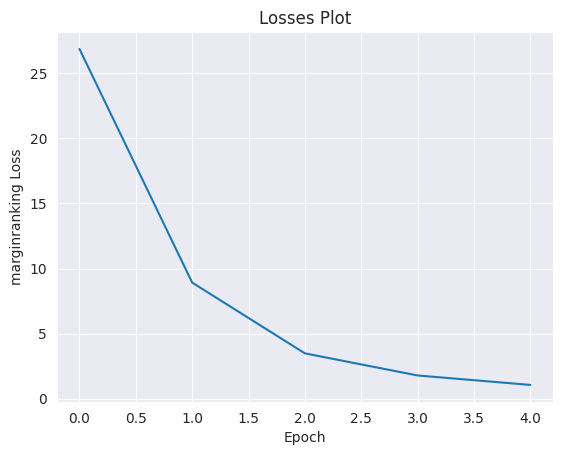

In [19]:
result.plot_losses()
plt.show()

In [20]:
result.metric_results.to_df()

,Side,Type,Metric,Value
0,head,optimistic,adjusted_arithmetic_mean_rank_index,0.386972
1,tail,optimistic,adjusted_arithmetic_mean_rank_index,0.366914
2,both,optimistic,adjusted_arithmetic_mean_rank_index,0.377203
3,head,realistic,adjusted_arithmetic_mean_rank_index,0.386972
4,tail,realistic,adjusted_arithmetic_mean_rank_index,0.366914
...,...,...,...,...
220,tail,realistic,adjusted_hits_at_k,0.002559
221,both,realistic,adjusted_hits_at_k,0.003778
222,head,pessimistic,adjusted_hits_at_k,0.004996
223,tail,pessimistic,adjusted_hits_at_k,0.002559


In [21]:
result.get_metric('mrr')

0.0023465282283723354

In [ ]:
from pykeen.hpo import hpo_pipeline_from_config

In [ ]:
config = {
    'optuna': dict(
        n_trials=5,
    ),
    'pipeline': dict(
        training = tf_train,
        validation = tf_valid,
        testing = tf_test,
        model='TransR',
        model_kwargs_ranges=dict(
               embedding_dim=dict(type=int, low=20, high=160, q=20),
        ),
        optimizer='Adam',
        optimizer_kwargs=dict(lr=0.01),
        loss='marginranking',
        loss_kwargs=dict(margin=1),
        training_loop='slcwa',
        training_kwargs=dict(num_epochs=100, batch_size=128),
        negative_sampler='basic',
        negative_sampler_kwargs=dict(num_negs_per_pos=1),
        evaluator_kwargs=dict(filtered=True),
        evaluation_kwargs=dict(batch_size=128),
        stopper='early',
        stopper_kwargs=dict(frequency=5, patience=2, relative_delta=0.002),
    )
}

In [ ]:
hpo_pipeline_result = hpo_pipeline_from_config(config)

In [ ]:
hpo_pipeline_result.save_to_directory('hpo_results')

In [22]:
from pykeen.pipeline import pipeline_from_config

In [ ]:
config2 = {
    "metadata": {
    "title": "nations - try",
    "comments": "comment"
  },
  "pipeline": {
    "dataset": "nations",
    "model": "TransE",
    "model_kwargs": {
      "embedding_dim": 50,
      "scoring_fct_norm": 1
    },
    "optimizer": "SGD",
    "optimizer_kwargs": {
      "lr": 0.01
    },
    "loss": "MarginRankingLoss",
    "loss_kwargs": {
      "reduction": "mean",
      "margin": 1
    },
    "training_loop": "slcwa",
    "negative_sampler": "basic",
    "negative_sampler_kwargs": {
      "num_negs_per_pos": 1
    },
    "training_kwargs": {
      "num_epochs": 100,
      "batch_size": 32
    },
    "evaluator_kwargs": {
      "filtered": True
    }
  }
}

pipeline_result = pipeline_from_config(config2)

In [ ]:
pipeline_result.metric_results.to_df()

## Result tracking

In [31]:
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset
from pykeen.trackers import ResultTracker


dataset = get_dataset(dataset="nations")

pipeline_result = pipeline(
    model='RotatE',
    dataset=dataset,
    result_tracker="console",
    result_tracker_kwargs = dict(metric_filter='.*head.realistic.hits_at_10.*'),
    training_kwargs = dict(
        num_epochs = 5,
        callbacks="validation-loss",
        callback_kwargs=dict(
            evaluation_triples=dataset.validation.mapped_triples,
            prefix="validation",
        ),
    )    
)



INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///work/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation


In [32]:
dataset

EagerDataset(num_entities=14, num_relations=55, create_inverse_triples=False, metadata={'name': 'nations'})